# Computational Mathematics 1: Exercise Sheet 1

## Example 1.1: Taylor Series Expansion

Recall that the Taylor-series expansion of a smooth function $f\colon\mathbb{R}\rightarrow\mathbb{R}$, i.e. 
$f\in\mathcal{C}^\infty$, at a point $a\in\mathbb{R}$ is given by:
$$
    f(x) = \sum_{n=0}^\infty \frac{\mathrm{d}^n f(a)}{\mathrm{d} x^n}\cdot\frac{(x-a)^n}{n!}
$$

The partial sum of order $k$ given by
$$
    T_k(x) = \sum_{n=0}^k \frac{\mathrm{d}^n f(a)}{\mathrm{d} x^n}\cdot\frac{(x-a)^n}{n!}
$$

Tasks:

1. Verify analytically that the Taylor-series expansion of the function $f(x)=\cos(x)$ at $x=0$ is given by:
   $$
    \cos(x) = \sum_{n=0}^\infty\frac{(-1)^n}{(2n)!}x^{2n}
   $$

2. Write a python-script containing two functions:
    1. A function `taylor_cos(x, k)` that prints the approximate function values `cos_approx` of $\cos(x)$ at the point
    $\frac{\pi}{4}$ using its Taylor polynomial of order $k$

    2. A function `taylor_plot(x_int, k)` that plots the function $\cos(x)$ and the Taylor polynomials of orders $k$ in
    a given interval `x_int`. Set the y-axis limits at $[-4,4]$. Test the function using $k=0,2,4,6,8$ in the interval
    $x\in[-2\pi,2\pi]$.

3. From subtask 2, compute the 1-norm error of approximating $\cos(\pi/4)$ using the Taylor polynomials and discuss your
   observations as you increase the order of the polynomials.

In [8]:
from numpy import ndarray, array, pi, linspace, cos as npcos, zeros, abs, arange, sqrt, column_stack, ceil, max, exp
from typing import Callable, Optional
from warnings import filterwarnings # used for catching RuntimeWarning
from matplotlib.pyplot import Axes
from scipy.special import factorial # approximates n! with Gamma(n+1) instead of Stirling
from matplotlib.lines import Line2D
from sys import stderr # only for error messages

import matplotlib.pyplot as plt
from pandas import DataFrame

# matplotlib setup

text_colors = {
    'jupyter': 'white',
    'regular': 'black'
}

mode = 'regular'
plot_params = {
    'axes.labelcolor': text_colors[mode],
    'xtick.color': text_colors[mode],
    'ytick.color': text_colors[mode],
    'text.usetex': True,
    'font.size': 18,
    'grid.linestyle': '--'
}

plt.rcParams.update(plot_params)

# util functions and constants

def list_to_string(l : list, delim : Optional[str] = ',') -> str:
    rstring = ''
    for i,x in enumerate(l):
        if i < len(l) - 1:
            rstring += f'{x},'
        else:
            rstring += str(x)
    return rstring
    
axis_resolution = 400
fig_height_in = 12
fig_width_in  = 12

The cell above is required to run the cells below, as it loads all required components and packages. You may notice that classes from the `typing` module are loaded. While not required for functionality, they allow me to write proper type-hints to keep the code maintainable and readable.

### Subtask 1: Analytic Verification

Given the derivative of $\cos(x)$ repeats cyclically with period four, we can sort them into four classes:
$$
    \frac{\mathrm{d}^n\cos}{\mathrm{d} x^n} = \begin{cases}
        \cos & n \equiv 0 \mod 4\\
        -\sin & n \equiv 1 \mod 4\\
        -\cos & n \equiv 2 \mod 4\\
        \sin & n \equiv 3 \mod 4
    \end{cases} \implies \frac{\mathrm{d}^n\cos}{\mathrm{d}x^n}(0) = (-1)^n\delta_{n \mod 2}
$$

Given that $\sin(0) = 0$ and $\cos(0)=1$, we get the series-expansion:
$$
    \cos(x) = \sum_{k=0}^\infty \frac{\cos^{(n)}(0)}{n!}x^n = \sum_{k=0}^\infty\frac{(-1)^n x^{2n}}{(2n!)}
$$


### Subtask 2: Taylor-Series implementation

We begin by writing a generic class for arbitrary power-series. This allows us a great level of abstraction and keeps 
the code modular and reuseable. Given a power series is uniquely defined by it's sequence $a_k$ and the point of 
development $a$, we only need to supply these two. Additionally, passing a keyword-argument `precomp` allows us to pre-compute sequence-values in order 
to save on computation time later on.
The real magic happens in the `__call__` method, which marks any instance `obj` of the class as callable, meaning 
we can simply use `obj(<xval>, <kval>)` in order to compute the $k$-th partial sum. If any sequence-values are 
computed in the constructor, these are of course used. For larger $k$ than supplied in `precomp`, the 
sequence-function is called per iteration.

Note that the power of $(x-a)$ is given by the function `self._int_x_power()`, which allows us to use exponents 
like $2n+1$ with a lambda expression. Additionally, large factorials become unwieldy, and `scipy` throws a
`RuntimeWarning` instance for too large values of $n$, thus if the warning is caught with the `except` statement, 
then iteration is aborted and the result returned immediately. Note that the instance will print a warning to 
`stderr`.

The `plot()` method allows us to pass an x-axis and an axes-object, and optionally a $k$ for the $k$-th partial sum,
and plot the values of the taylor-series for each value in the passed x-axis. The method returns the line-object 
created by `ax.plot()`.


In [9]:
class PowerSeries:
    def __init__(self, sequence : Callable[[int], float],
                       devpoint : Optional[float] = 0.0,
                       **kwargs) -> None:
        self._seq = sequence
        self._devpoint = devpoint
        self._precomp = kwargs.get('precomp', 0)
        self._int_x_power = kwargs.get('xpower', lambda n: 1)
        self.__gen_max = 100
        
        if self._precomp > 0:
            self._seqvals = array([0.0] * self._precomp)
            for k in range(self._precomp):
                self._seqvals[k] = self._seq(k)
                
    def __call__(self, x : float, k : Optional[int] = 20) -> float:
        rval : float = 0.0
        filterwarnings('error')
        for k in range(k+1):
            try:
                if k < self._precomp:
                    rval += self._seqvals[k] * ( x - self._devpoint) ** (self._int_x_power(k))
                else:
                    rval += self._seq(k) * ( x - self._devpoint) ** (self._int_x_power(k))
            except RuntimeWarning:
                print(f'encountered runtime warning at index {k}, aborting summation', file=stderr)
                break
        return rval

    def arrval(self, x_vals : ndarray, k : Optional[int] = 20) -> ndarray:
        return array([self(x,k) for x in x_vals])

    def plot(self, x_axis : ndarray, ax : Axes, k : Optional[int] = 20, **kwargs) -> Line2D:
        return ax.plot(x_axis, self(x_axis, k))[0]

Given a generic class for handling power series, we can now simply create a child-class and change how we construct
the object. We now only define a function computing the derivative of $f$ at $a$ and pass a lambda dividing by 
a, possibly changed, factorial, i.e. for $\cos(x)$ we can pass `n_multiplies = lambda n : 2*n`

In [10]:
class TaylorSeries(PowerSeries):
    
    def __init__(self, derivatives : Callable[[int, float], float],
                       devpoint : Optional[float] = 0.0,
                       n_multiplies : Optional[Callable[[int],int]] = lambda n : n,
                       **kwargs) -> None:
        sequence = lambda n : derivatives(n, devpoint) / factorial(n_multiplies(n) )
        self._name = kwargs.get('name', 'f')
        super().__init__(sequence, devpoint, xpower= n_multiplies, precomp = kwargs.get('precomp', 0))

    def dispval(self, x : float = 0.25 * pi) -> None:
        print(f'{self._name}({x}) = {self(x)}')
        
    def compare_plots(self, x : ndarray, 
                            k_values : ndarray,
                            ax : Axes, true_values : ndarray,
                            **kwargs) -> list:
        y_limits = kwargs.get('ylimits', (-4,4))
        
        if y_limits[0] >= y_limits[1]:
            raise ValueError('supplied y-limits are invalid!')
        
        if kwargs.get('grid', False):
            ax.grid()
        
        l0 = ax.plot(x, true_values, label=fr'${self._name}(x)$')
        lines = []
        for k in k_values:
            lines.append(ax.plot(x, self.arrval(x, k), label=r'$T_{'  + f'{k}' + r'}(x)$'))
        title = fr'Approximations for ${self._name}$' + r' with orders $k\in\{' + f'{list_to_string(k_values)}' + r'\}$'
        ax.set_title(title, color=text_colors[mode])
        ax.set_ylim(y_limits[0], y_limits[1])
        return [l0].append(lines)
    
    def check_error(self, x : float,
                          true : float, 
                          k_values : ndarray) -> ndarray:
        return array([abs(self(x,k) - true) for k in k_values])
    
    def check_errors(self, x : ndarray,
                           true : ndarray,
                           k : Optional[int] = 10) -> ndarray:
        return abs(self.arrval(x, k) - true)

Given this sub-class, we can now simply set `derivatives = lambda n, x : (-1)**n` and 
`n_multiplies = lambda n : 2*n`, to produce the taylor-polynomials of $\cos(x)$. 

In [11]:
taylor_cos = TaylorSeries(lambda n, x : (-1)**n, 0.0, lambda n : 2*n)
x_val = pi / 4
k_vals = [0,2,4,6,8]
taylor_vals = array([taylor_cos(x_val, k) for k in k_vals])

display(DataFrame({
    'k' : k_vals,
    'T_k': taylor_vals,
}))

,k,T_k
0,0,1.000000
1,2,0.707429
2,4,0.707107
3,6,0.707107
4,8,0.707107


Using the `compare_plots()` method, we can pass any x-axis, axes-object and set of valid 
values of $k$ to produce a plot displaying all the taylor-polynomials and the true-function values passed via `true`. 
See the figure below. Note how the taylor-polynomials of order $k$ are listed in the given order in the legend, so 
one can differentiate the various plots.

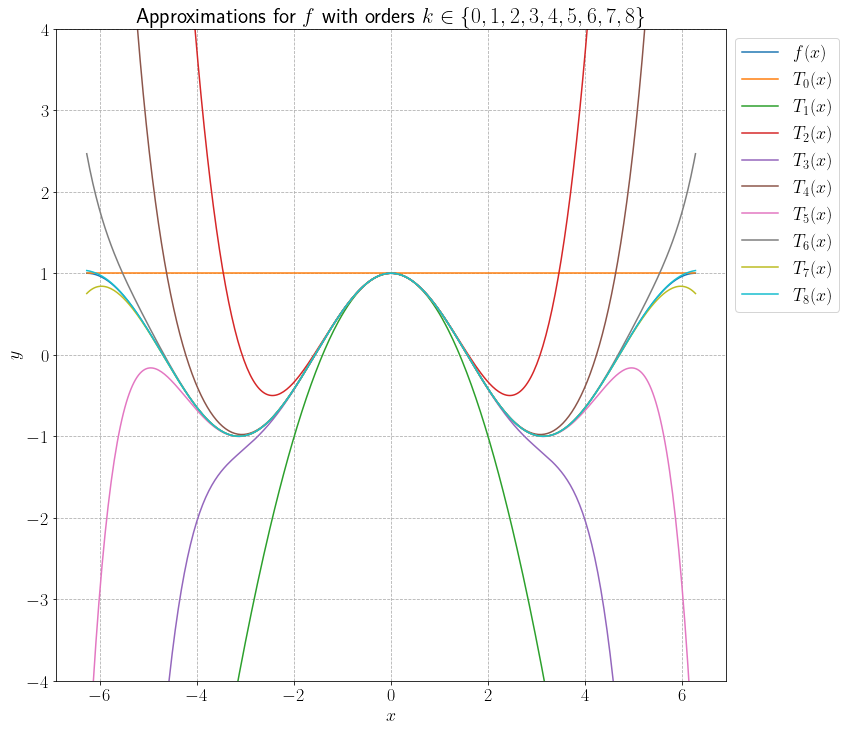

In [18]:
fig, ax = plt.subplots()
x = linspace(-2*pi, 2*pi, axis_resolution)
taylor_cos.compare_plots(x, [0,1,2,3,4,5,6,7,8], ax, npcos(x), grid=True)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.set_size_inches(fig_width_in, fig_height_in)
plt.show()

###

### Subtask 3: Absolute Error

We already implemented the two methods `TaylorSeries.check_error()` and `TaylorSeries.check_errors()` which respectively
compute the absolute error of the $k$-taylor-polynomials for a certain $x$ or an arbitrary x-axis of values for a 
fixed $k$. Given that $\cos\left(\frac{\pi}{4}\right) = \frac{\sqrt{2}}{2}$, we can very easily compute the 
error of our cosine-approximation.

,k,error
0,0,2.928932e-01
1,1,1.553192e-02
2,2,3.224255e-04
3,3,3.566364e-06
4,4,2.449675e-08
5,5,1.146229e-10
6,6,3.886891e-13
7,7,1.110223e-15
8,8,1.110223e-16
9,9,1.110223e-16


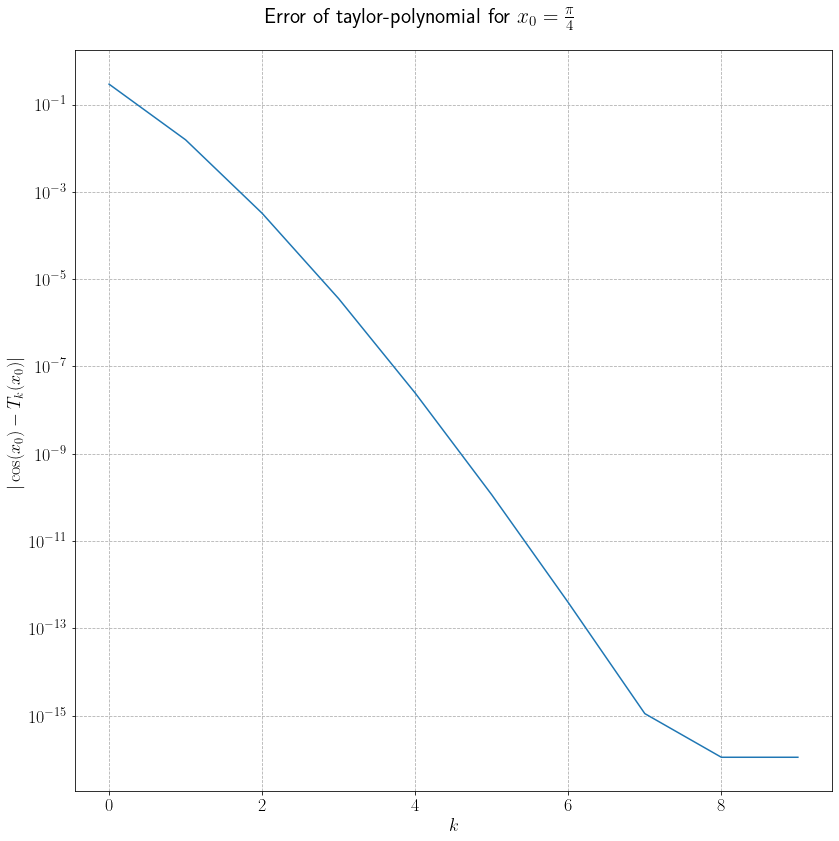

In [19]:
k_min = 0
k_top = 9
k_step = 1
k_values = arange(k_min, k_top + k_step, k_step, dtype=int)
true_single = sqrt(2.0) * 0.5
x_val = pi * 0.25
errors = taylor_cos.check_error(x_val, true_single, k_values)

display(DataFrame({
    'k': k_values,
    'error': errors,
}))

fig, ax = plt.subplots()
ax.semilogy(k_values, errors)
ax.grid()
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$|\cos(x_0) - T_k(x_0)|$')
fig.set_size_inches(fig_width_in, fig_height_in)
fig.suptitle(r'Error of taylor-polynomial for $x_0 = \frac{\pi}{4}$', color=text_colors[mode])
fig.tight_layout()
plt.show()

We observe that for rising $k$, the absolute error $|\cos - T_k|$ quickly decreases (note that the y-axis is 
logarithmic) and seems to reach an equilibrium point of approximately $1.11\cdot 10^{-16}$ (see the table above).

Below we use the method `check_errors()` to compute the absolute error of the taylor-polynomial over an arbitrary 
axis, and plot the error.

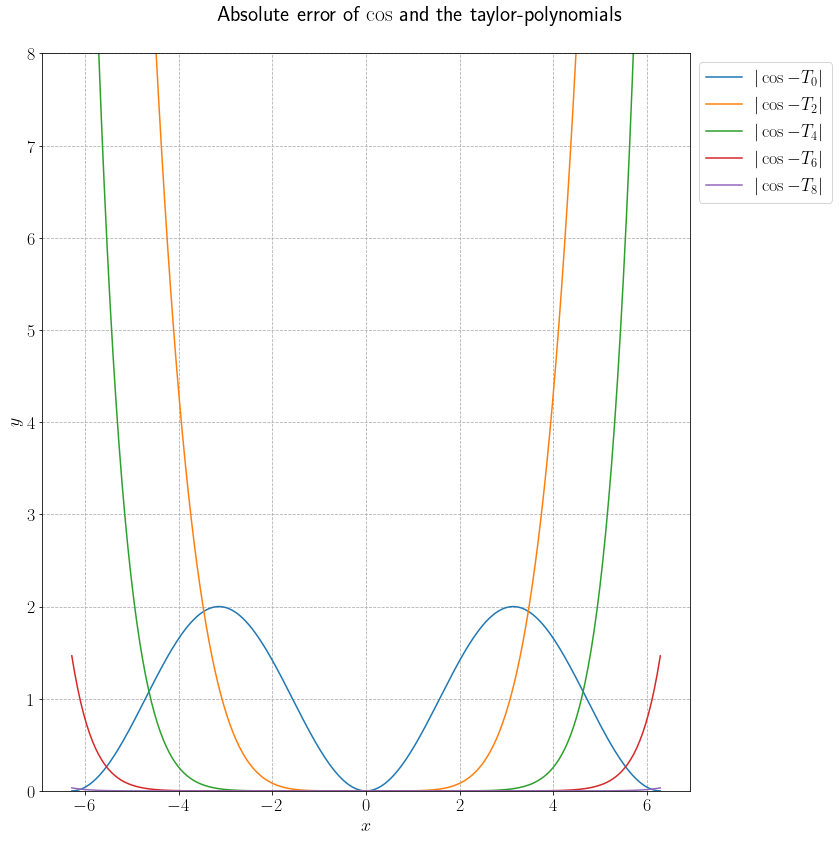

In [16]:
k_min = 0
k_top = 8
k_step = 2
k_values = arange(k_min, k_top + k_step, k_step)
x_axis = linspace(-2*pi, 2*pi, axis_resolution)
true_values = npcos(x_axis)
fig, ax = plt.subplots()

for k in k_values:
    errors = taylor_cos.check_errors(x_axis, true_values, k)
    ax.plot(x_axis, errors, label=r'$|\cos - T_{' f'{k}'+ r'}|$')
    
ax.legend(bbox_to_anchor=(1, 1))
fig.set_size_inches(fig_width_in, fig_width_in)
ax.grid()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_ylim(0,8)
fig.suptitle(r'Absolute error of $\cos$ and the taylor-polynomials')
fig.tight_layout()
plt.show()